# Machine Learning for Banking: Analytics Vidhya

Have you ever wondered how lenders use various factors such as credit score, annual income, the loan amount approved, tenure, debt-to-income ratio etc. and select your interest rates? 

The process, defined as ‘risk-based pricing’, uses a sophisticated algorithm that leverages different determining factors of a loan applicant. Selection of significant factors will help develop a prediction algorithm which can estimate loan interest rates based on clients’ information. On one hand, knowing the factors will help consumers and borrowers to increase their credit worthiness and place themselves in a better position to negotiate for getting a lower interest rate. On the other hand, this will help lending companies to get an immediate fixed interest rate estimation based on clients information. 

#### Here, our goal is to use a training dataset to predict the loan rate category (1 / 2 / 3) that will be assigned to each loan in our test set.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [2]:
train = pd.read_csv('train_banking.csv')
test = pd.read_csv('test_banking.csv')

In [3]:
train.head(5)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [4]:
test.head(5)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,"27,500",10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
1,10164311,"26,000",10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,"6,075",< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
3,10164313,"12,000",10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
4,10164314,"35,000",< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,26.0,9,21,Male


In [5]:
train.shape, test.shape

((164309, 14), (109541, 13))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
Loan_ID                    164309 non-null int64
Loan_Amount_Requested      164309 non-null object
Length_Employed            156938 non-null object
Home_Owner                 138960 non-null object
Annual_Income              139207 non-null float64
Income_Verified            164309 non-null object
Purpose_Of_Loan            164309 non-null object
Debt_To_Income             164309 non-null float64
Inquiries_Last_6Mo         164309 non-null int64
Months_Since_Deliquency    75930 non-null float64
Number_Open_Accounts       164309 non-null int64
Total_Accounts             164309 non-null int64
Gender                     164309 non-null object
Interest_Rate              164309 non-null int64
dtypes: float64(3), int64(5), object(6)
memory usage: 17.6+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109541 entries, 0 to 109540
Data columns (total 13 columns):
Loan_ID                    109541 non-null int64
Loan_Amount_Requested      109541 non-null object
Length_Employed            104605 non-null object
Home_Owner                 92830 non-null object
Annual_Income              92643 non-null float64
Income_Verified            109541 non-null object
Purpose_Of_Loan            109541 non-null object
Debt_To_Income             109541 non-null float64
Inquiries_Last_6Mo         109541 non-null int64
Months_Since_Deliquency    50682 non-null float64
Number_Open_Accounts       109541 non-null int64
Total_Accounts             109541 non-null int64
Gender                     109541 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 10.9+ MB


In [8]:
# To determine the % of null values in train dataset
for feature in train:
    print(feature,':', np.round(train[feature].isnull().mean() *100, 3), '% of missing values')

Loan_ID : 0.0 % of missing values
Loan_Amount_Requested : 0.0 % of missing values
Length_Employed : 4.486 % of missing values
Home_Owner : 15.428 % of missing values
Annual_Income : 15.277 % of missing values
Income_Verified : 0.0 % of missing values
Purpose_Of_Loan : 0.0 % of missing values
Debt_To_Income : 0.0 % of missing values
Inquiries_Last_6Mo : 0.0 % of missing values
Months_Since_Deliquency : 53.788 % of missing values
Number_Open_Accounts : 0.0 % of missing values
Total_Accounts : 0.0 % of missing values
Gender : 0.0 % of missing values
Interest_Rate : 0.0 % of missing values


- There are 4 features, having the missing values: (a. Length_Employed, b.Home_Owner , c. Annual_Income , d. Months_Since_Deliquency.
- Months_Since_Deliquency feature has almost 54% missing values, so dropping this feature.
- Home_Owner and Annual_Income have almost same amount of missing values which might indicate that for a particular record both Home_Owner and Annual_Income are missing.

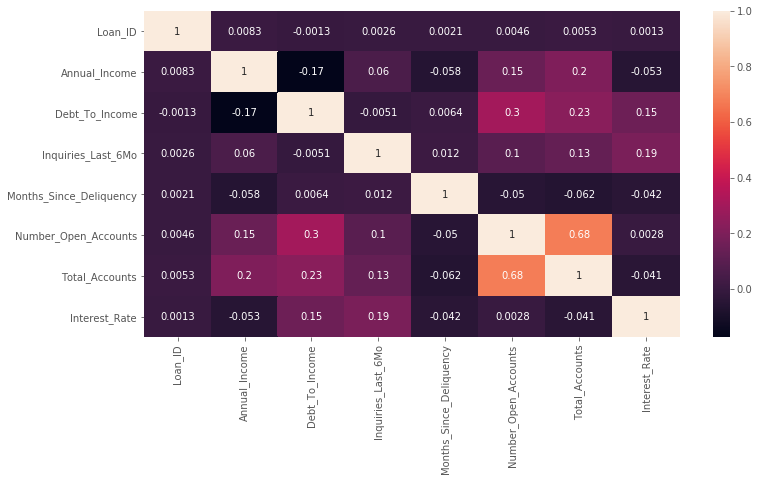

In [9]:
plt.figure(figsize = (12,6))
ax = sns.heatmap(train.corr(), annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.show()

In [10]:
## Lets replace Length_Employed with most frequent or mode value as it is a categorical feature
train['Length_Employed'].fillna(train['Length_Employed'].value_counts().idxmax(), inplace = True)

In [11]:
train["Length_Employed"].value_counts().idxmax()

'10+ years'

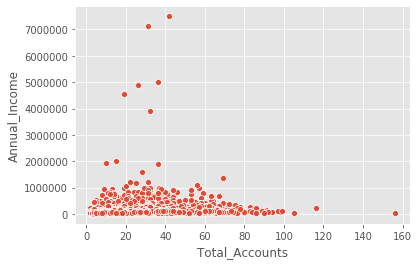

In [12]:
sns.scatterplot(train['Total_Accounts'], train['Annual_Income'])
plt.show()

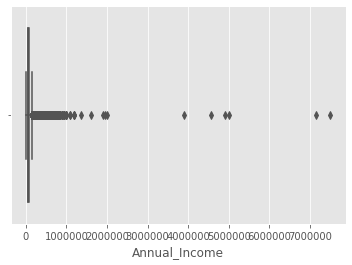

In [13]:
sns.boxplot(train['Annual_Income'])
plt.show()

In [14]:
train['Annual_Income'].median()

63000.0

In [15]:
train['Annual_Income'].mean()

73331.15943386468

Since we have all the outliers of the Annual_Income on the higher side, we'll be imputing the missing value with mean of Annual_Income.

In [16]:
## For Annual_Income we can replace with mean 

train["Annual_Income"].fillna(train["Annual_Income"].mean(),inplace=True)

In [17]:
## Lets replace Home_Owner with most frequent or mode value as it is a categorical feature

train['Home_Owner'].fillna(train['Home_Owner'].value_counts().idxmax(), inplace = True)

#### Droping "Months_Since_Deliquency" feature since it has more than 54% of the values missing.

In [18]:
train.drop("Months_Since_Deliquency", axis=1, inplace=True)

In [19]:
## Checking if all the null values of train dataset have been treated
train.isnull().sum()

Loan_ID                  0
Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Total_Accounts           0
Gender                   0
Interest_Rate            0
dtype: int64

In [20]:
# To determine the % of null values in test dataset
for feature in test:
    print(feature,':', np.round(test[feature].isnull().mean() *100, 3), '% of missing values')

Loan_ID : 0.0 % of missing values
Loan_Amount_Requested : 0.0 % of missing values
Length_Employed : 4.506 % of missing values
Home_Owner : 15.255 % of missing values
Annual_Income : 15.426 % of missing values
Income_Verified : 0.0 % of missing values
Purpose_Of_Loan : 0.0 % of missing values
Debt_To_Income : 0.0 % of missing values
Inquiries_Last_6Mo : 0.0 % of missing values
Months_Since_Deliquency : 53.732 % of missing values
Number_Open_Accounts : 0.0 % of missing values
Total_Accounts : 0.0 % of missing values
Gender : 0.0 % of missing values


In [21]:
#### Droping "Months_Since_Deliquency" feature since it has more than 54% of the values missing.

In [22]:
test.drop("Months_Since_Deliquency", axis=1, inplace=True)

In [23]:
## Lets replace Length_Employed with most frequent or mode value as it is a categorical feature
test['Length_Employed'].fillna(test['Length_Employed'].value_counts().idxmax(), inplace = True)

## For Annual_Income we can replace with mean 
test["Annual_Income"].fillna(test["Annual_Income"].mean(),inplace=True)

## Lets replace Home_Owner with most frequent or mode value as it is a categorical feature
test['Home_Owner'].fillna(test['Home_Owner'].value_counts().idxmax(), inplace = True)

In [24]:
## Checking if all the null values of test dataset have been treated
test.isnull().sum()

Loan_ID                  0
Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Total_Accounts           0
Gender                   0
dtype: int64

## EDA

### Dependent Feature

In [25]:
train['Interest_Rate'].describe()

count    164309.000000
mean          2.158951
std           0.738364
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: Interest_Rate, dtype: float64

In [26]:
train['Interest_Rate'].value_counts()

2    70580
3    59923
1    33806
Name: Interest_Rate, dtype: int64

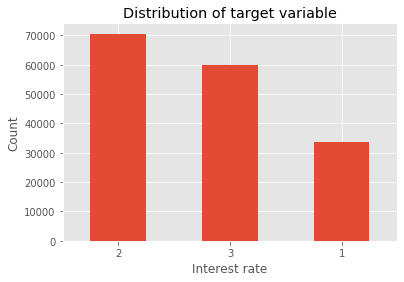

In [27]:
train['Interest_Rate'].value_counts().plot(kind = 'bar')
plt.xlabel("Interest rate")
plt.xticks(rotation = 360)
plt.ylabel("Count")
plt.title("Distribution of target variable")
plt.show()

## Independent Feature

#### 1. Loan_Amount_Requested

In [28]:
train['Loan_Amount_Requested'] = train['Loan_Amount_Requested'].str.replace(',', '')

In [29]:
train['Loan_Amount_Requested'] = train['Loan_Amount_Requested'].astype(int)

In [30]:
train['Loan_Amount_Requested'].describe()

count    164309.00000
mean      14349.33692
std        8281.86870
min         500.00000
25%        8000.00000
50%       12075.00000
75%       20000.00000
max       35000.00000
Name: Loan_Amount_Requested, dtype: float64

In [31]:
test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].str.replace(',', '')

In [32]:
test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].astype(int)

In [33]:
test['Loan_Amount_Requested'].describe()

count    109541.000000
mean      14358.475137
std        8299.811736
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: Loan_Amount_Requested, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

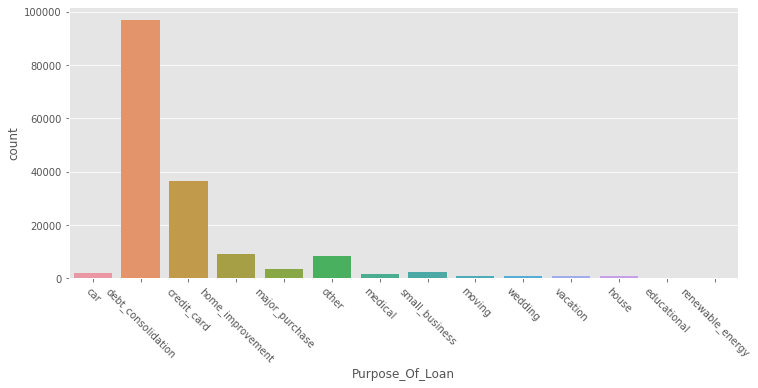

In [34]:
plt.figure(figsize=(12,5))
sns.countplot(train.Purpose_Of_Loan)
plt.xticks(rotation=-45)

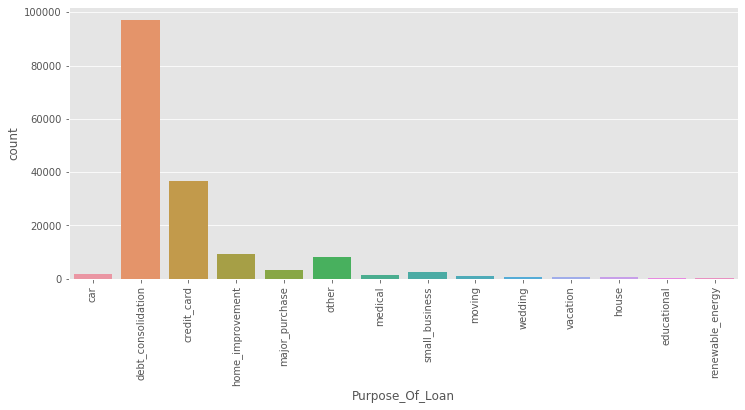

In [35]:
plt.figure(figsize = (12,5))
sns.countplot(train['Purpose_Of_Loan'])
plt.xticks(rotation = 90)
plt.show()

Most of the borrowers are seeking a loan for debt consolidation and then followed by credit card payment.

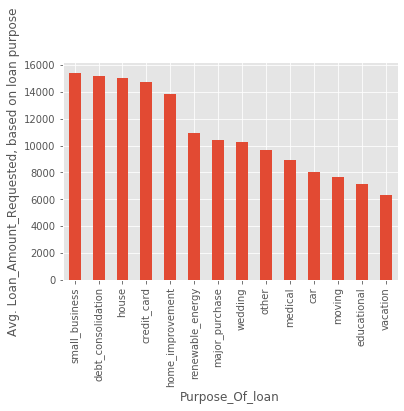

In [36]:
train.groupby('Purpose_Of_Loan')['Loan_Amount_Requested'].mean().sort_values(ascending=False).plot(kind = 'bar')
plt.xlabel("Purpose_Of_loan")
plt.ylabel("Avg. Loan_Amount_Requested, based on loan purpose")
plt.show()

#### The borrowers having, Purpose_Of_Loan as "small_business" have requested a high Loan_Amount.

In [37]:
train.groupby('Purpose_Of_Loan')['Loan_Amount_Requested'].mean().sort_values(ascending=False)

Purpose_Of_Loan
small_business        15427.456104
debt_consolidation    15148.553568
house                 15042.205692
credit_card           14754.313870
home_improvement      13867.466825
renewable_energy      10958.130081
major_purchase        10394.657933
wedding               10239.402174
other                  9635.493051
medical                8913.854640
car                    8053.806366
moving                 7668.814168
educational            7110.123967
vacation               6300.627240
Name: Loan_Amount_Requested, dtype: float64

- The average amount requested for loan is highest for Small business, followed by debt_consolidation and home.

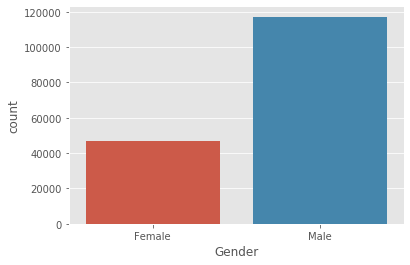

In [38]:
# Gender
sns.countplot(train.Gender)
plt.show()

- Most of the Male applicants have applied for a loan.

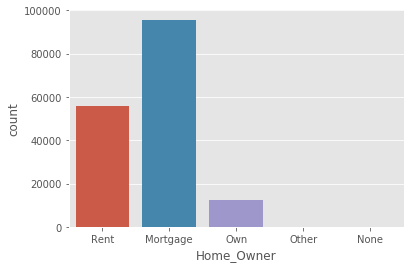

In [39]:
sns.countplot(train.Home_Owner)

- Most of the applicants have either Mortgaged their house or are staying in a rented house.

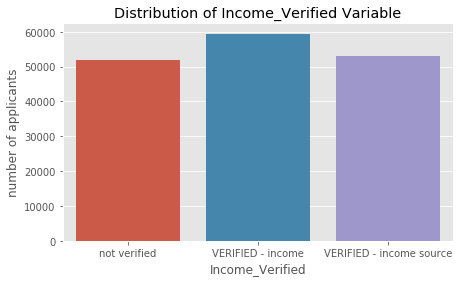

In [40]:
plt.figure(figsize=(7,4))
sns.countplot(train.Income_Verified)
plt.title("Distribution of Income_Verified Variable")
plt.ylabel("number of applicants")
plt.show()

- Most of the borrower's income or the income source have been verified.

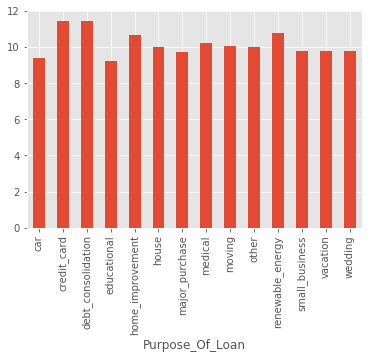

In [41]:
train.groupby('Purpose_Of_Loan')['Number_Open_Accounts'].mean().plot(kind='bar')
plt.show()

The borrowers who have taken loan for the credit_card and debt_consolidation purposes have the highest no of accounts open on an average.

### Feature affect while comparing the Dependent features with the independent feature

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

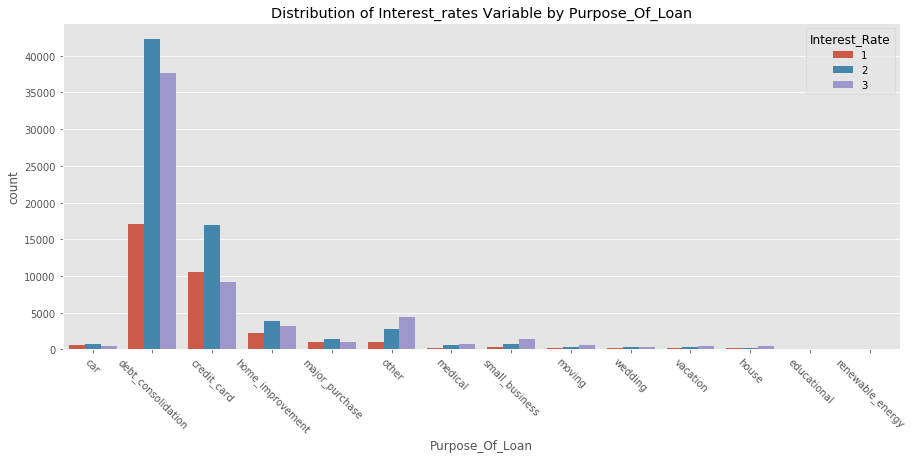

In [42]:
plt.figure(figsize=(15,6))
sns.countplot(x=train.Purpose_Of_Loan,hue=train.Interest_Rate)
plt.title("Distribution of Interest_rates Variable by Purpose_Of_Loan")
plt.xticks(rotation=-45)

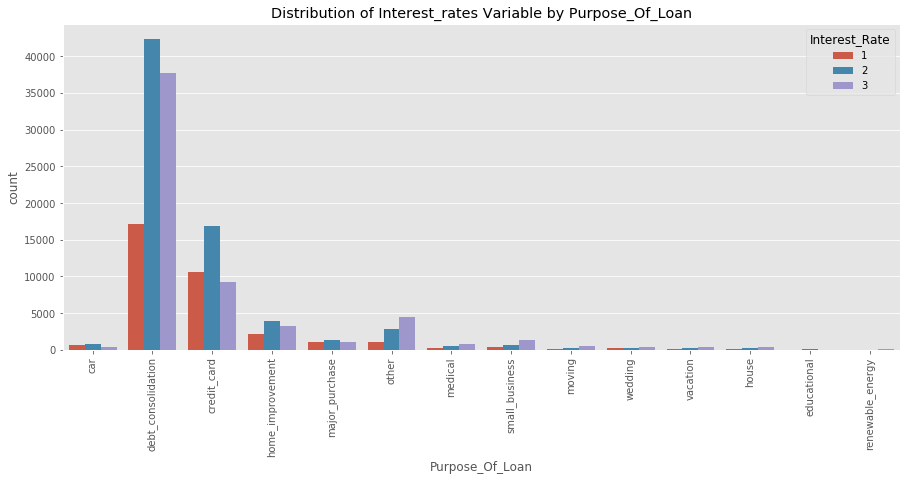

In [43]:
plt.figure(figsize = (15,6))
sns.countplot(train['Purpose_Of_Loan'], hue = train.Interest_Rate)
plt.title("Distribution of Interest_rates Variable by Purpose_Of_Loan")
plt.xticks(rotation=90)
plt.show()

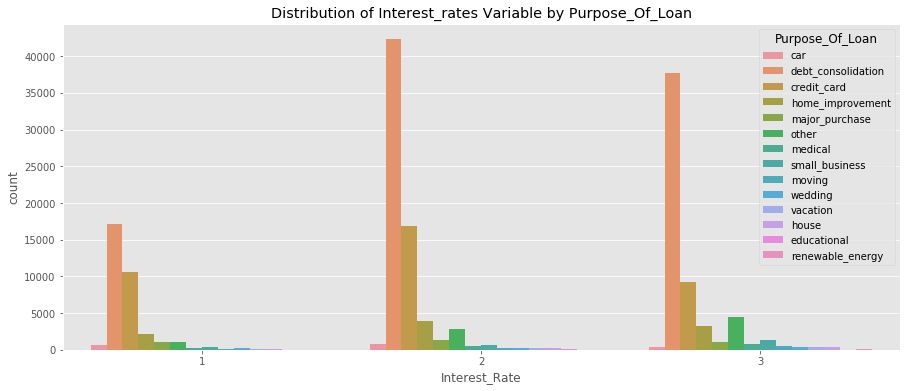

In [44]:
plt.figure(figsize=(15,6))
sns.countplot(x=train.Interest_Rate,hue=train.Purpose_Of_Loan)
plt.title("Distribution of Interest_rates Variable by Purpose_Of_Loan")
plt.xticks(rotation=360)
plt.show()

- All the Interest rates are higher for debt_consolidation and credit card since the loan amount is also high for these cases.

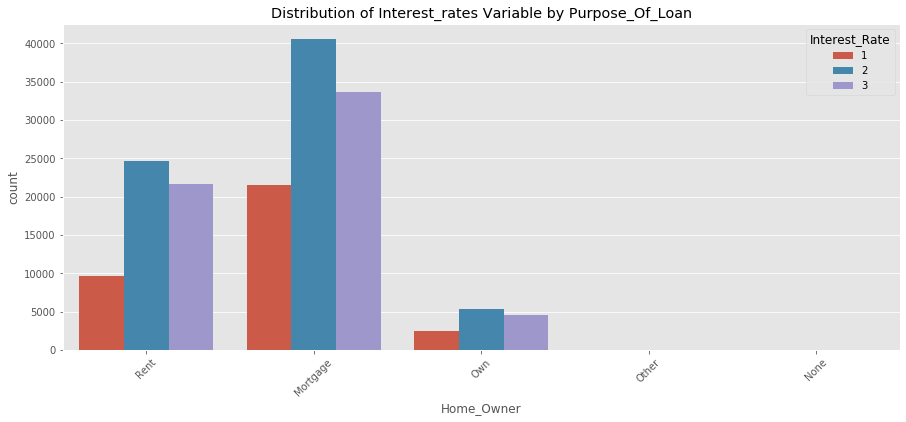

In [45]:
plt.figure(figsize=(15,6))
sns.countplot(x=train.Home_Owner,hue=train.Interest_Rate)
plt.title("Distribution of Interest_rates Variable by Purpose_Of_Loan")
plt.xticks(rotation=45)
plt.show()

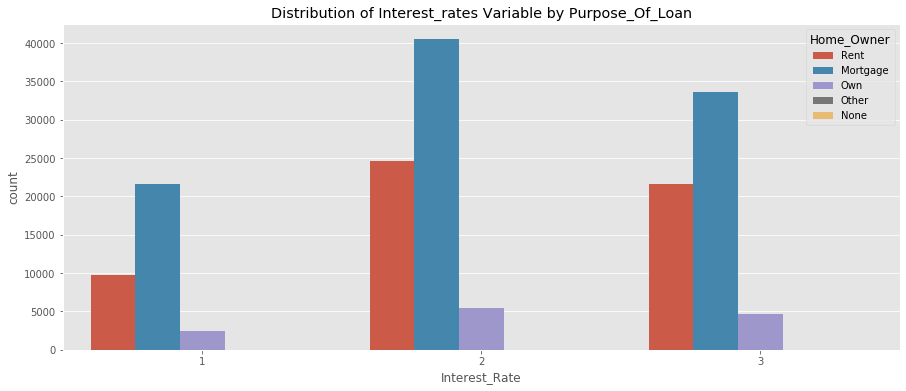

In [46]:
plt.figure(figsize=(15,6))
sns.countplot(x=train.Interest_Rate,hue=train.Home_Owner)
plt.title("Distribution of Interest_rates Variable by Purpose_Of_Loan")
plt.xticks(rotation=360)
plt.show()

Interest rate 2 and 3 is highest for rent and Mortgage.

In [47]:
numerical_feature = train.select_dtypes(include='number')
discrete_feature = [feature for feature in numerical_feature if len(train[feature].unique()) < 25 and feature not in ['Id']]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature+['Id']]
print("Discrete Feature Count: {}".format(len(discrete_feature)))
print()
print("Continuous Feature Count: {}".format(len(continuous_feature)))

Discrete Feature Count: 2

Continuous Feature Count: 6


In [48]:
train[discrete_feature].head(5)

,Inquiries_Last_6Mo,Interest_Rate
0,0,1
1,0,3
2,0,3
3,3,3
4,1,1


In [49]:
train[continuous_feature].head(5)

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Number_Open_Accounts,Total_Accounts
0,10000001,7000,68000.000000,18.37,9,14
1,10000002,30000,73331.159434,14.93,12,24
2,10000003,24725,75566.400000,15.88,12,16
3,10000004,16000,56160.000000,14.34,16,22
4,10000005,17000,96000.000000,22.17,19,30


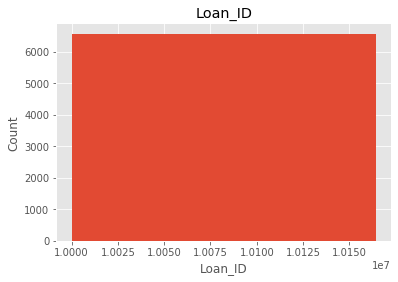

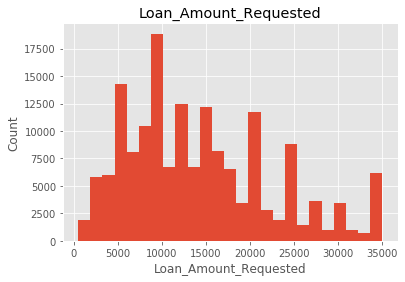

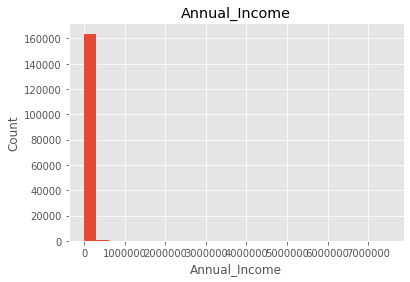

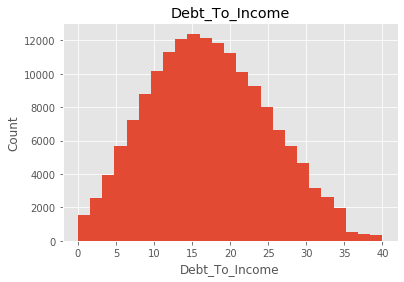

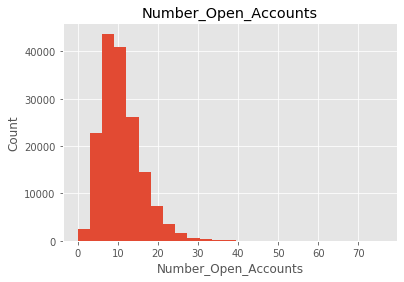

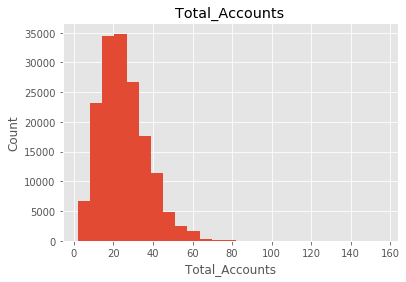

In [50]:
## Lets analyze the continuous feature values by creating histograms to understand the distribution

for feature in continuous_feature:
    df = train.copy()
    df[feature].hist(bins = 25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

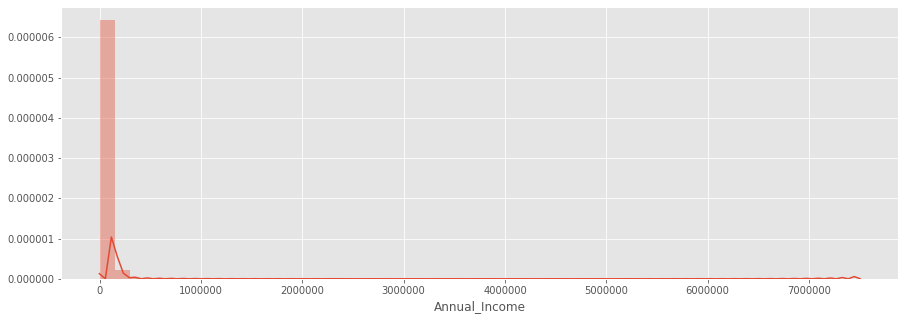

In [51]:
plt.figure(figsize=(15,5))
sns.distplot(train.Annual_Income)

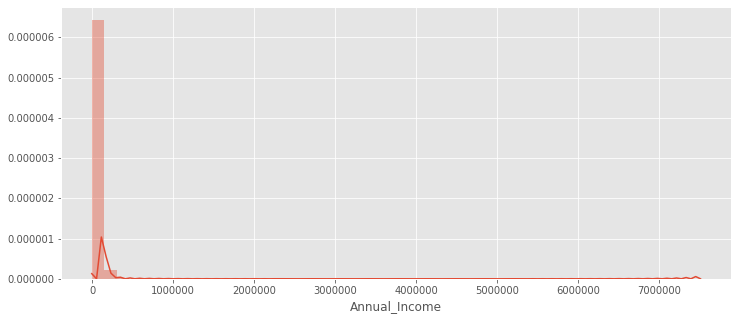

In [52]:
plt.figure(figsize = (12,5))
sns.distplot(train['Annual_Income'])
plt.show()

Most of the applicants have annual income less than 100000.

### Treating Outliers

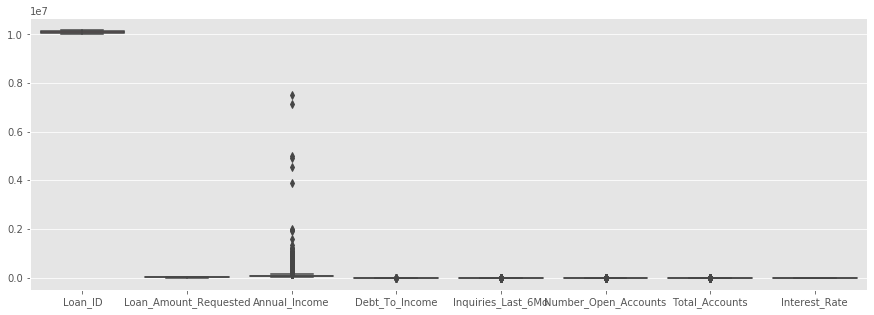

In [53]:
plt.figure(figsize = (15,5))
sns.boxplot(data = train)
plt.show()

In [54]:
x = train.describe()
x.head(5)

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Interest_Rate
count,1.643090e+05,164309.00000,164309.000000,164309.000000,164309.000000,164309.000000,164309.000000,164309.000000
mean,1.008216e+07,14349.33692,73331.159434,17.207189,0.781698,11.193818,25.067665,2.158951
std,4.743207e+04,8281.86870,55574.394150,7.845083,1.034747,4.991813,11.583067,0.738364
min,1.000000e+07,500.00000,4000.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,1.004108e+07,8000.00000,48600.000000,11.370000,0.000000,8.000000,17.000000,2.000000


In [55]:
for i in numerical_feature:
    q1=x.loc['25%',i]
    q3=x.loc['75%',i]
    iqr=q3-q1
    uppl=q3+(1.5*iqr)
    lowl=q1-(1.5*iqr)
    train[i]=train[i].apply(lambda x:uppl if x>uppl else x )
    train[i]=train[i].apply(lambda x: lowl if x<lowl else x)
    print(i, uppl, lowl)

Loan_ID 10246463.0 9917847.0
Loan_Amount_Requested 38000.0 -10000.0
Annual_Income 132100.0 -1500.0
Debt_To_Income 39.895 -5.745000000000003
Inquiries_Last_6Mo 2.5 -1.5
Number_Open_Accounts 23.0 -1.0
Total_Accounts 54.5 -5.5
Interest_Rate 4.5 0.5


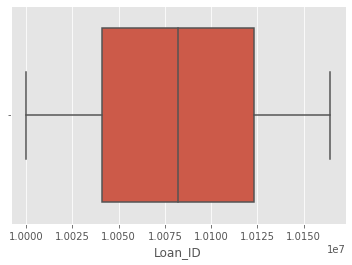

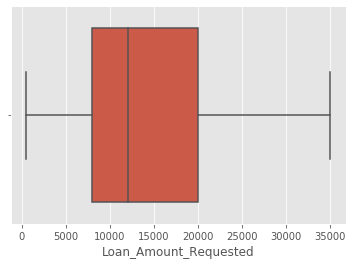

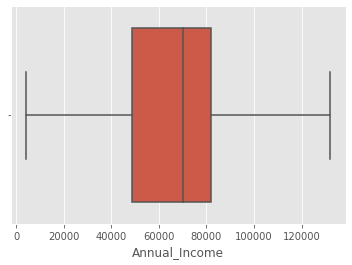

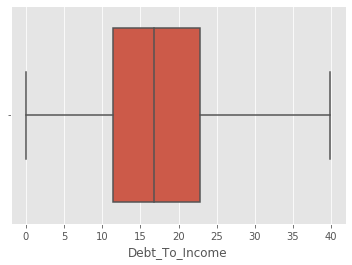

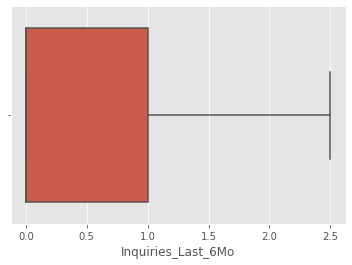

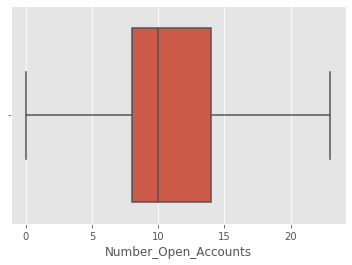

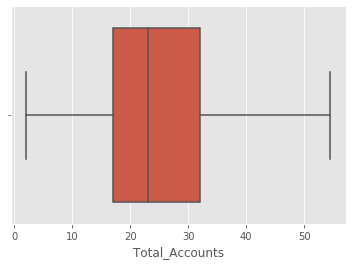

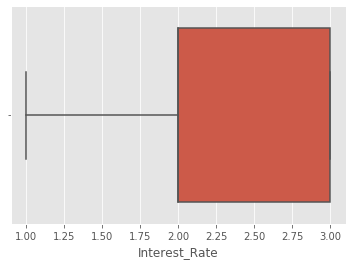

In [56]:
for i in numerical_feature:
    sns.boxplot(train[i])
    plt.show()

There are no outliers.

In [57]:
num_features = test.select_dtypes(include='number')

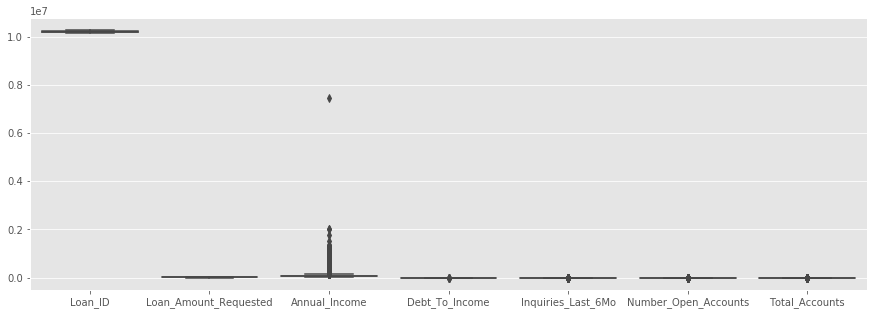

In [58]:
plt.figure(figsize = (15,5))
sns.boxplot(data = test)
plt.show()

In [59]:
for i in num_features:
    q1=x.loc['25%',i]
    q3=x.loc['75%',i]
    iqr=q3-q1
    uppl=q3+(1.5*iqr)
    lowl=q1-(1.5*iqr)
    test[i]=test[i].apply(lambda x:uppl if x>uppl else x )
    test[i]=test[i].apply(lambda x: lowl if x<lowl else x)
    print(i, uppl, lowl)

Loan_ID 10246463.0 9917847.0
Loan_Amount_Requested 38000.0 -10000.0
Annual_Income 132100.0 -1500.0
Debt_To_Income 39.895 -5.745000000000003
Inquiries_Last_6Mo 2.5 -1.5
Number_Open_Accounts 23.0 -1.0
Total_Accounts 54.5 -5.5


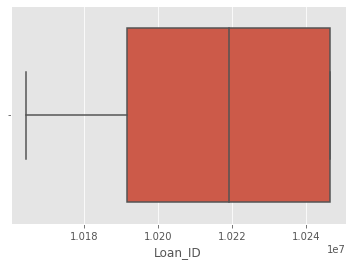

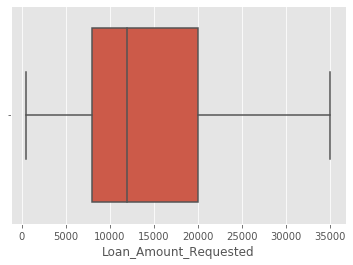

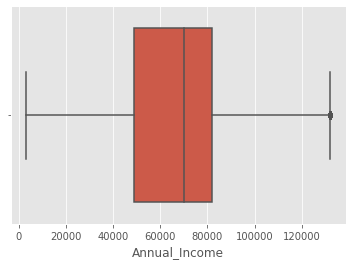

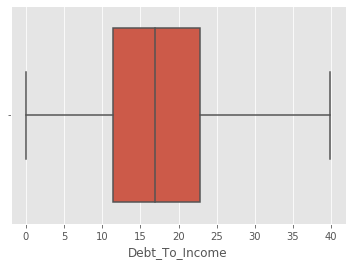

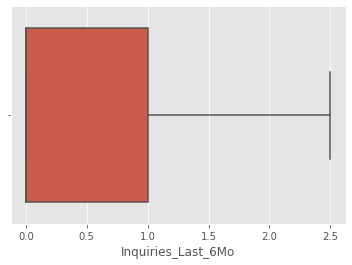

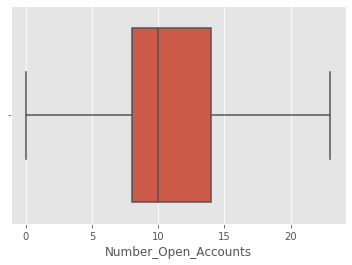

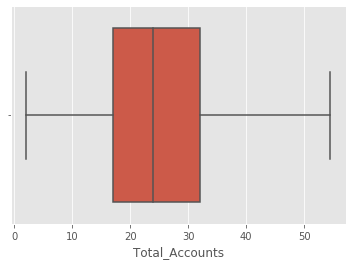

In [60]:
for i in num_features:
    sns.boxplot(test[i])
    plt.show()

### Encoding Categorical features

In [61]:
train.select_dtypes(include='object').columns

Index(['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan',
       'Gender'],
      dtype='object')

In [62]:
data_dummy = pd.get_dummies(train, columns=['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan',
       'Gender'], drop_first = True)
data_dummy

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Interest_Rate,Length_Employed_10+ years,Length_Employed_2 years,...,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Gender_Male
0,10000001,7000,68000.000000,18.37,0.0,9.0,14.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10000002,30000,73331.159434,14.93,0.0,12.0,24.0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10000003,24725,75566.400000,15.88,0.0,12.0,16.0,3,0,0,...,0,0,0,0,0,0,0,0,0,1
3,10000004,16000,56160.000000,14.34,2.5,16.0,22.0,3,0,0,...,0,0,0,0,0,0,0,0,0,1
4,10000005,17000,96000.000000,22.17,1.0,19.0,30.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,10164305,20725,73331.159434,13.56,0.0,13.0,16.0,2,1,0,...,0,0,0,0,0,0,0,0,0,1
164305,10164306,6000,73331.159434,9.12,0.0,13.0,30.0,2,0,0,...,0,0,0,0,0,0,1,0,0,1
164306,10164307,20250,73331.159434,18.17,1.0,17.0,30.0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
164307,10164308,10000,73331.159434,18.75,1.0,16.0,54.5,3,0,0,...,0,1,0,0,0,0,0,0,0,0


In [63]:
data_test_dummy=pd.get_dummies(test,columns=['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan',
       'Gender'], drop_first=True)
data_test_dummy

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Length_Employed_10+ years,Length_Employed_2 years,Length_Employed_3 years,...,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Gender_Male
0,10164310.0,27500,129000.0,12.87,0.0,10.0,37.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,10164311.0,26000,110000.0,11.37,0.0,6.0,23.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,10164312.0,6075,75000.0,6.83,2.0,5.0,20.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,10164313.0,12000,73000.0,7.76,0.0,6.0,8.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,10164314.0,35000,132100.0,9.62,0.0,9.0,21.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109536,10246463.0,15000,120000.0,8.15,2.0,13.0,54.5,0,0,0,...,0,0,0,0,1,0,0,0,0,1
109537,10246463.0,9600,125000.0,9.08,1.0,9.0,34.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
109538,10246463.0,2000,37850.0,11.60,0.0,10.0,11.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
109539,10246463.0,2125,30000.0,24.88,0.0,5.0,6.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


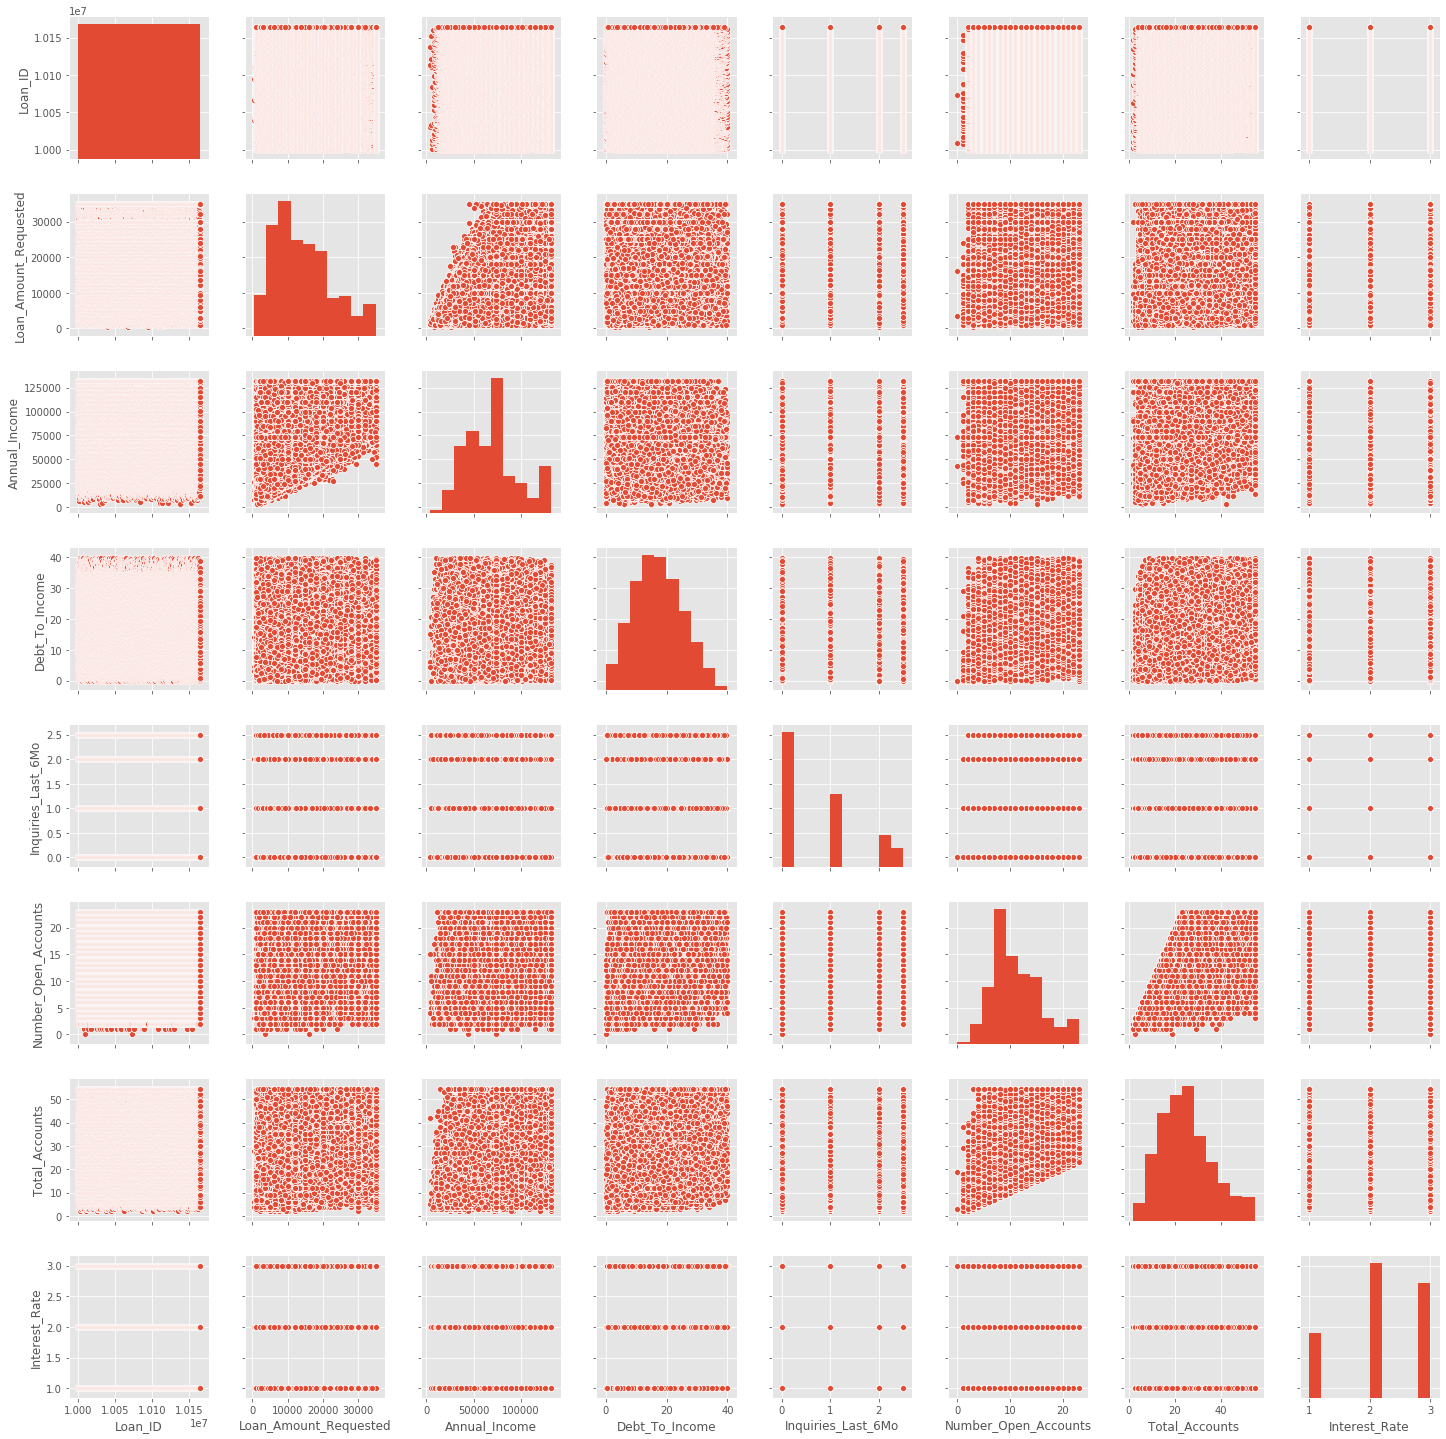

In [64]:
sns.pairplot(train)
plt.show()

C:\Users\satyam\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\satyam\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


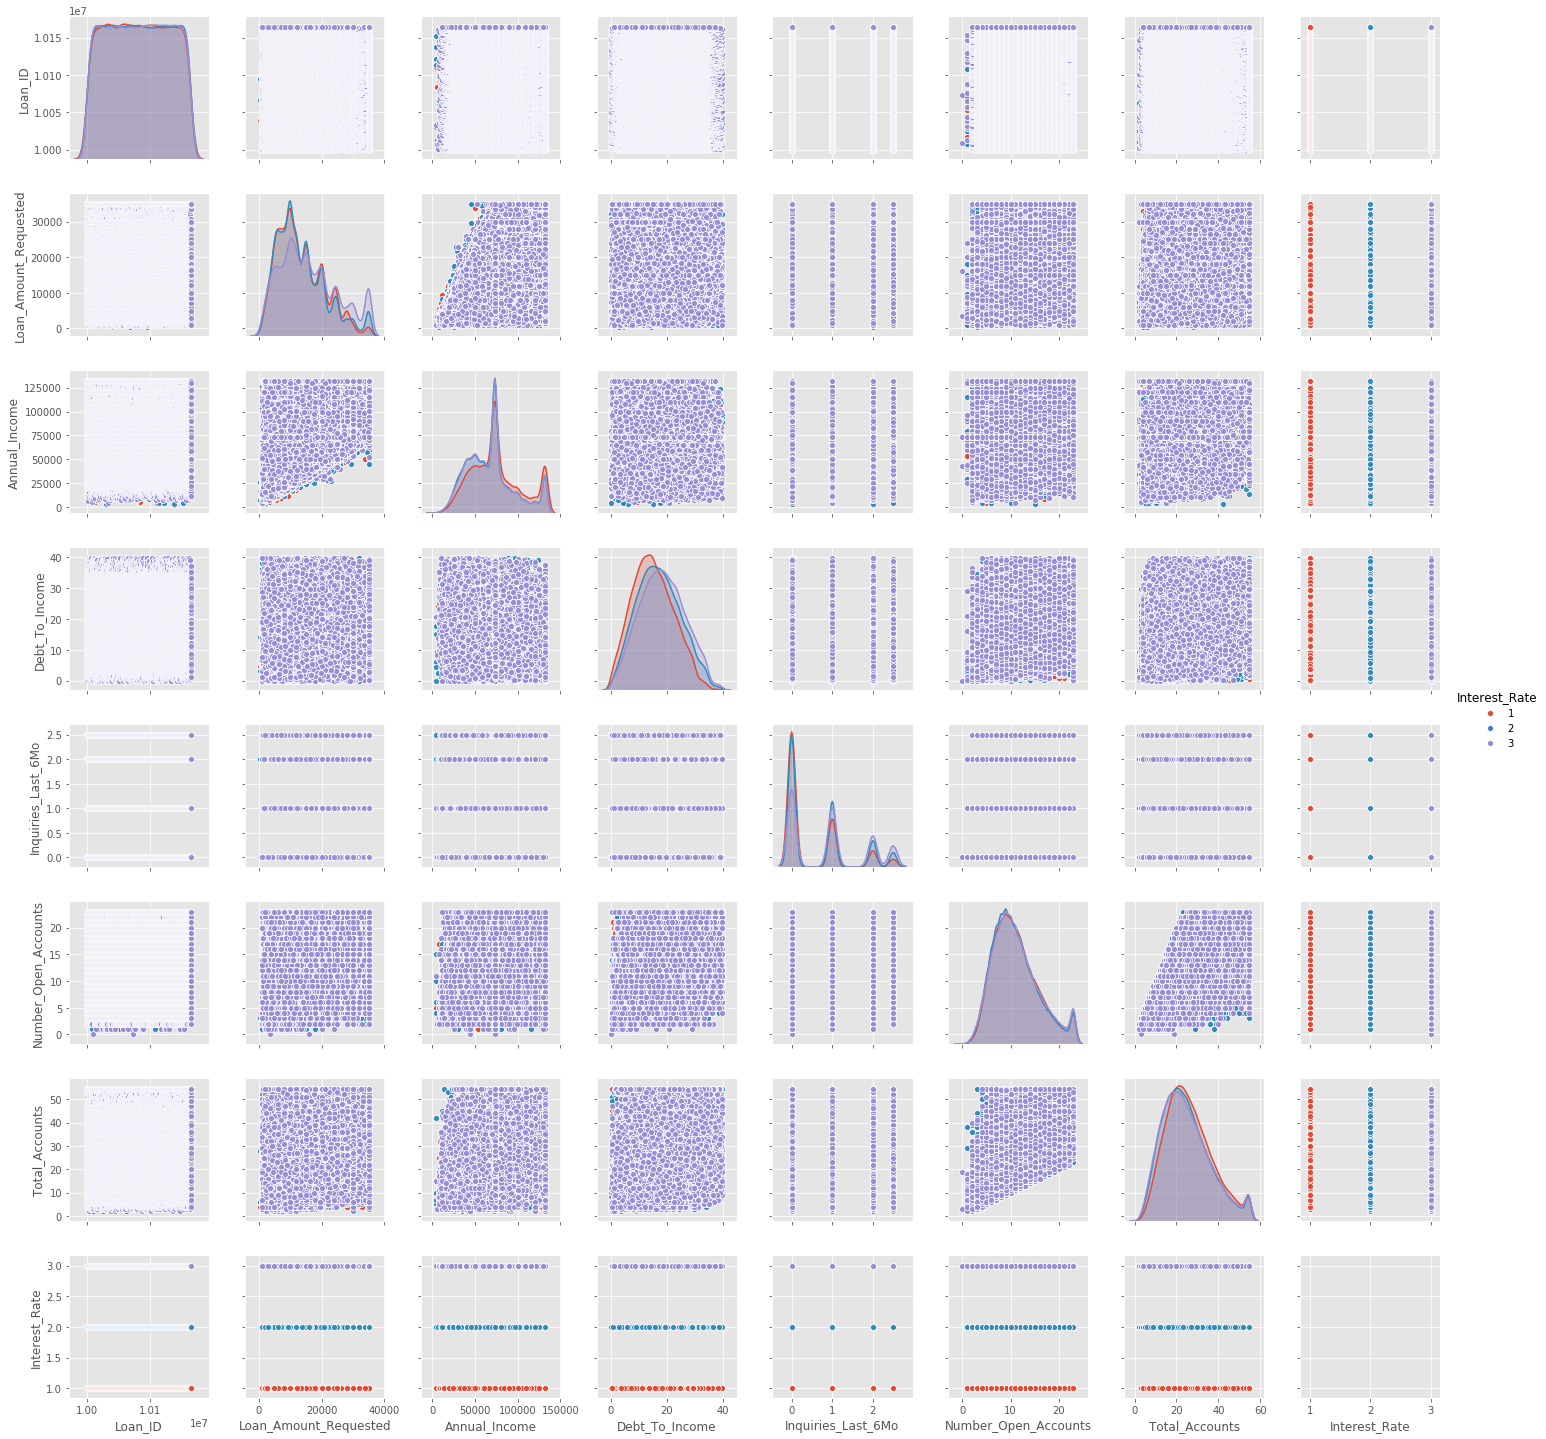

In [65]:
sns.pairplot(train, hue='Interest_Rate')

### Model: Decision Tree Classifier

In [66]:
y = data_dummy.Interest_Rate
X = data_dummy.drop('Interest_Rate', axis=1)

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(131447, 37)
(32862, 37)
(131447,)
(32862,)


In [68]:
cols = X_train.columns

In [69]:
from sklearn.preprocessing import MinMaxScaler

In [70]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

X.shape, y.shape

((164309, 37), (164309,))

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_test = pd.DataFrame(X_test, columns=[cols])

### Random Forest Classifier model with default parameters

In [71]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)


# fit the model
rfc.fit(X_train, y_train)


# Predict the Test set results
y_pred = rfc.predict(X_test)


# Check accuracy score 
from sklearn.metrics import accuracy_score
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

C:\Users\satyam\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model accuracy score with 10 decision-trees : 0.4688


### Random Forest Classifier model with 100 Decision Trees

In [72]:
# instantiate the classifier with n_estimators = 100
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set
rfc_100.fit(X_train, y_train)

# Predict on the test set results
y_pred_100 = rfc_100.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.5042


### Find important features with Random Forest model 

In [73]:
# create the classifier with n_estimators = 100
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [74]:
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

Debt_To_Income                              0.149174
Loan_ID                                     0.140320
Loan_Amount_Requested                       0.133665
Annual_Income                               0.119860
Total_Accounts                              0.114808
Number_Open_Accounts                        0.096377
Inquiries_Last_6Mo                          0.034815
Gender_Male                                 0.022200
Income_Verified_not verified                0.018134
Length_Employed_10+ years                   0.017176
Home_Owner_Rent                             0.014389
Income_Verified_VERIFIED - income source    0.011502
Length_Employed_2 years                     0.010717
Home_Owner_Own                              0.010486
Length_Employed_3 years                     0.010086
Length_Employed_< 1 year                    0.009790
Length_Employed_5 years                     0.009326
Purpose_Of_Loan_credit_card                 0.008872
Length_Employed_4 years                     0.

In [75]:
# drop the least important feature from X_train and X_test

# X_train = X_train.drop(['Home_Owner_Other', 'Home_Owner_None', 'Purpose_Of_Loan_renewable_energy','Purpose_Of_Loan_educational'], axis=1)
# X_test = X_test.drop(['Home_Owner_Other', 'Home_Owner_None', 'Purpose_Of_Loan_renewable_energy','Purpose_Of_Loan_educational'], axis=1)

#### Building the random forest model again and checking accuracy by dropping least important feature.

In [76]:
# instantiate the classifier with n_estimators = 100
# clf = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set
# clf.fit(X_train, y_train)

# Predict on the test set results
# y_pred = clf.predict(X_test)

# Check accuracy score 
# print('Model accuracy score with Home_Owner_Other, Home_Owner_None variable removed : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [77]:
# from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[1971 3544 1222]
 [2353 7699 3994]
 [1030 5312 5737]]


### Model: Light GB

- Parameter Tuning

In [78]:
kf = StratifiedKFold(n_splits=5,shuffle=False,random_state=42)

In [79]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',objective='multiclass',num_class=3,random_state=42,n_jobs=-1,verbose=1,)
params = {"max_depth":[4,6,8,10,-1],
          "learning_rate":[0.001,0.005,0.01,0.05,0.1,0.3],
          "subsample":[0.5,0.6,0.7,0.8,0.9],
          "colsample_bytree":[0.5,0.6,0.7,0.8,0.9],
          "reg_alpha":[0,0.25,0.5,1,2],
          "reg_lambda":[0,0.25,0.5,1,2],
          "num_leaves":[7,15,31,63,127],
          "min_data_in_leaf":[1,3,5,7,10,25],
          "n_estimators":list(range(50,1001,50))}
random_search = RandomizedSearchCV(estimator=clf,param_distributions=params,cv=kf.split(X,y),scoring='accuracy')
random_search.fit(X,y)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000019C8ECF4C48>,
                   error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_class=3,...
                                        'min_data_in_leaf': [1, 3, 5, 7, 10,
                                                             25],
                                        'n_estimator

In [80]:
random_search.best_estimator_,random_search.best_params_,random_search.best_score_

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
                importance_type='split', learning_rate=0.01, max_depth=4,
                min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=7,
                min_split_gain=0.0, n_estimators=900, n_jobs=-1, num_class=3,
                num_leaves=63, objective='multiclass', random_state=42,
                reg_alpha=2, reg_lambda=0.25, silent=True, subsample=0.5,
                subsample_for_bin=200000, subsample_freq=0, verbose=1),
 {'subsample': 0.5,
  'reg_lambda': 0.25,
  'reg_alpha': 2,
  'num_leaves': 63,
  'n_estimators': 900,
  'min_data_in_leaf': 7,
  'max_depth': 4,
  'learning_rate': 0.01,
  'colsample_bytree': 0.6},
 0.5191681526879234)

In [81]:
scores = {'last':0,'current':0}

In [82]:
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
                importance_type='split', learning_rate=0.05, max_depth=8,
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=10, min_split_gain=0.0, n_estimators=450,
                n_jobs=-1, num_class=3, num_leaves=31, objective='multiclass',
                random_state=42, reg_alpha=0.25, reg_lambda=1, silent=True,
                subsample=0.6, subsample_for_bin=200000, subsample_freq=0,
                verbose=1)

lgbm.fit(X_train, y_train,eval_set = (X_test,y_test), early_stopping_rounds=150, verbose=0)

y_pred = lgbm.predict(X_test)

scores['current'] = f1_score(y_test, y_pred, average='weighted')
print('previous score = ', scores['last'],
      '\ncurrent score = ', scores['current'])
scores['last'] = scores['current']

previous score =  0 
current score =  0.5035065784912915


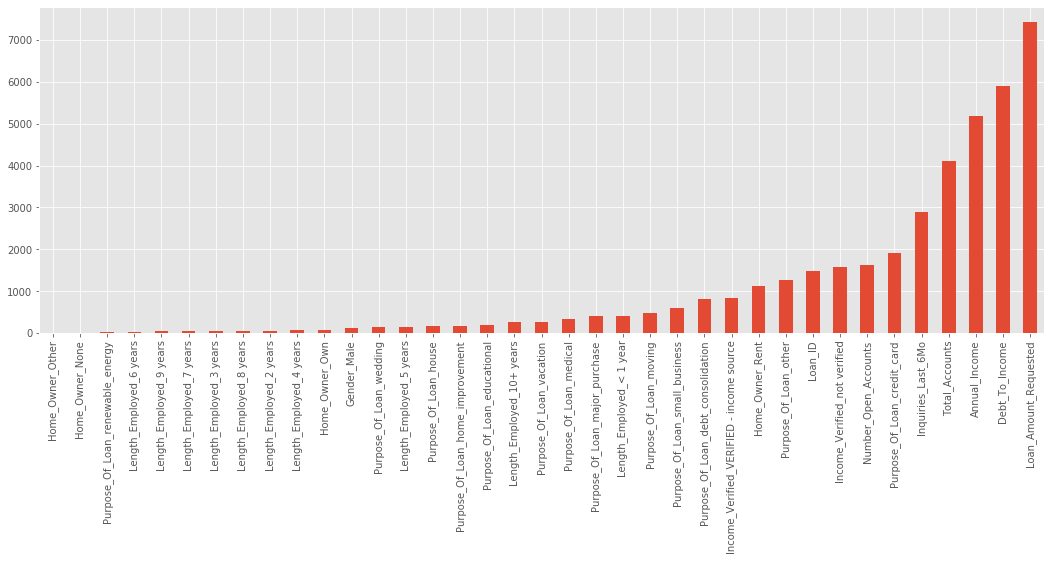

In [83]:
plt.figure(figsize=(18,6))
ser = pd.Series(random_search.best_estimator_.feature_importances_,X.columns).sort_values()
ser.plot(kind='bar')

In [85]:
# Creating Submission dataframe with just Loan_ID column.
Submission=test[['Loan_ID']]
test.drop("Loan_ID",axis=1,inplace=True)

In [86]:
Submission['Interest_Rate'] = lgbm.predict(data_test_dummy)
Submission.to_csv("Sub_11.csv",index=None)

C:\Users\satyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
pd.read_csv('Sub_11.csv')

,Loan_ID,Interest_Rate
0,10164310.0,2
1,10164311.0,2
2,10164312.0,3
3,10164313.0,2
4,10164314.0,2
...,...,...
109536,10246463.0,3
109537,10246463.0,2
109538,10246463.0,2
109539,10246463.0,3
